# train

In [1]:
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp

import utils
import metrics
import time
import plot
from svgd import SVGD

rkey = random.PRNGKey(10)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
dist = metrics.Gaussian(0, 1)
dist = metrics.GaussianMixture([-3, 3], [1, 1], [1/3, 2/3])
n = 100
d = dist.d

n_steps = 1000
svgd = SVGD(dist, n_steps, particle_shape=(n, d), adagrad=False)

In [3]:
h = 30
lr = 0.01
svgd_stepsize = 0.01
bandwidth = h
ksd_bandwidth = 1

In [4]:
rkey = random.split(rkey)[0]

### train

In [5]:
st = time.time()
x, x_step, log, log_step, losses = svgd.train(rkey, h, lr, svgd_stepsize, n_steps, ksd_bandwidth, update_after=0)
x.block_until_ready()
end = time.time()
print(f"took {end - st} seconds")

  0%|          | 1/1000 [00:02<38:46,  2.33s/it]

JIT COMPILING step...
...done compiling step after 0.462313175201416 seconds.


100%|██████████| 1000/1000 [00:37<00:00, 26.57it/s]

took 38.08681654930115 seconds


JIT COMPILING svgd...
...done compiling svgd after 0.9095652103424072 seconds.
took 6.140190839767456 seconds


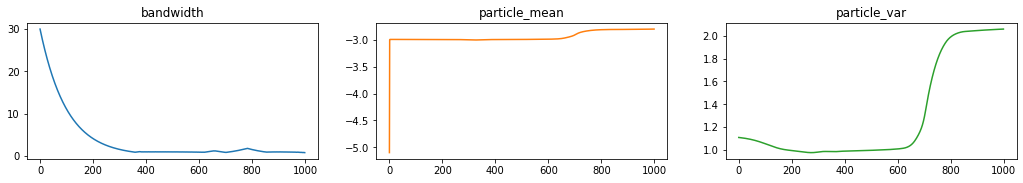

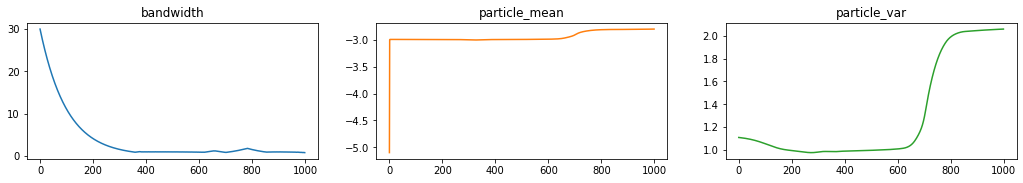

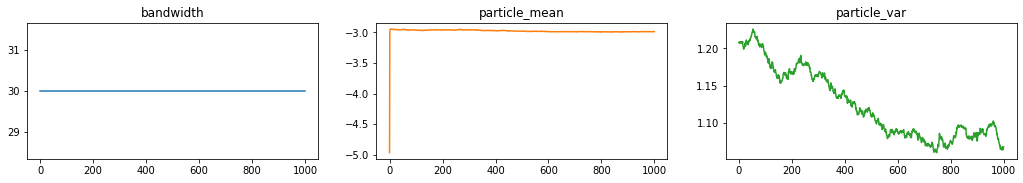

In [6]:
st = time.time()
x0 = svgd.initialize(rkey)
xs, logs = svgd.svgd(x0, svgd_stepsize, h, n_steps)
end = time.time()
print(f"took {end - st} seconds")

plot.svgd_log(log)

plot.svgd_log(log_step)

plot.svgd_log(logs)

In [7]:
np.all(logs["x0"] == log["x0"])

DeviceArray(True, dtype=bool)

In [8]:
log["desc"]["bandwidth"][-10:]

DeviceArray([[0.77197766],
             [0.7642964 ],
             [0.7566915 ],
             [0.7642964 ],
             [0.77197766],
             [0.7642964 ],
             [0.7566915 ],
             [0.7491623 ],
             [0.74170804],
             [0.7343279 ]], dtype=float32)

# Histograms

## Learned bandwidth

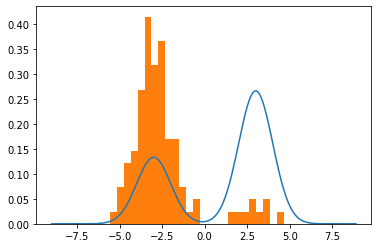

In [9]:
grid = np.arange(-9, 9, 0.1)

_ = plt.plot(grid, vmap(dist.pdf)(grid))
_ = plt.hist(x[:, 0], density=True, bins=25)

## Fixed bandwidth

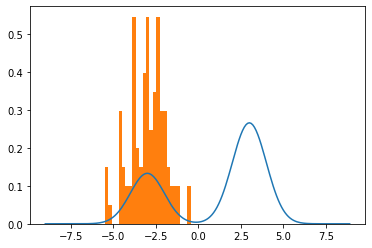

In [10]:
grid = np.arange(-9, 9, 0.1)

_ = plt.plot(grid, vmap(dist.pdf)(grid))
_ = plt.hist(xs[:, 0], density=True, bins=25)

# compare sample

In [11]:
s = dist.sample(shape=(n,))

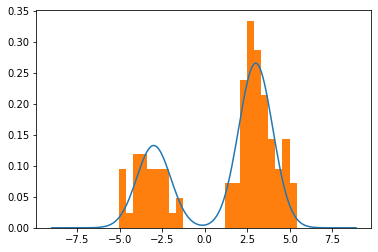

In [12]:
_ = plt.plot(grid, vmap(dist.pdf)(grid))
_ = plt.hist(s, density=True, bins=25)

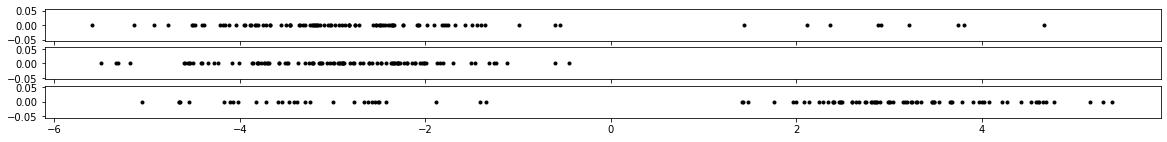

In [13]:
figs, axs = plt.subplots(3, figsize=[20, 2])
# figs.tight_layout = True

titles = ["Learned", "Fixed", "True random"]
samples = [x[:, 0], xs[:, 0], s]
mins = []
maxs = []

for ax, t, sam in zip(axs, titles, samples):
    ax.plot(sam, np.zeros(100), "k.")
#     ax.set_title(t)
    lims = ax.get_xlim()
    mins.append(lims[0])
    maxs.append(lims[1])

lims = [min(mins), max(maxs)]
for ax in axs:
    ax.set_xlim(lims)

In [14]:
s = s[:, np.newaxis]

In [15]:
dist.compute_metrics(s)

{'square_errors': DeviceArray([[6.8476364e-02],
              [2.2049265e+00],
              [6.3382741e-04],
              [8.9069243e-07]], dtype=float32),
 'ksds': DeviceArray([93.13162   ,  2.4818583 ,  0.81468934], dtype=float32)}

In [16]:
dist.compute_metrics(x)

{'square_errors': DeviceArray([[1.1922771e+01],
              [1.3397079e-03],
              [1.0548576e-07],
              [1.0004920e-02]], dtype=float32),
 'ksds': DeviceArray([1.0787982e+02, 1.6888175e-03, 3.6158293e-04], dtype=float32)}

In [17]:
dist.compute_metrics(xs)

{'square_errors': DeviceArray([[1.5909040e+01],
              [3.2694661e-06],
              [7.7450252e-04],
              [2.0240728e-02]], dtype=float32),
 'ksds': DeviceArray([1.1092920e+02, 1.2548589e+00, 2.4671410e-03], dtype=float32)}